# (Self Study) Gradient descent

In this notebook, we will implement inference for a ___binary classification___ problem using mini-batch gradient descent. The approach is very similar to [notebook 3 in the pre-course assignments](preparation/notebook-3-gradient.ipynb).

## Reminder

### Formal representation of the problem

Let's look at a binary classification model

$
\quad y_i = \cases{1 \quad \text{if}\ z_i^* > 0\\0 \quad \text{otherwise}}
$

that represents our hypothesis $h$, with

$
\quad z_i^* = \beta_{(k)} f\left( x_i^{(k)} \right) + \varepsilon_i
$

Here, 

- $y_i$ is the dependent variable,
- $x_i$ the feature vector, and
- $\beta$ are the coefficients (or weights).

Assuming a logistic distribution for the error term leads to a closed form solution for class probabilities

$
\quad p(y_i = 1) =  \displaystyle\frac{
\exp\left\{ z_i \right\}
}{
1 + \exp\left\{ z_i \right\}
}
=
\displaystyle\frac{1}{
1 + \exp\left\{ -z_i \right\}
}
$

### Update equations

Gradient descent starts with an initial guess for $\beta$ and then iterates to minimize the cost function $J$ (i.e., maximize the LL function). With the learning rate $\alpha$, it follows

$
\quad\displaystyle \beta_k' \\
\quad\quad= \beta_k - \alpha\,\partial_\beta J(\theta) \\
\quad\quad= \beta_k - \alpha\,\displaystyle\sum_i \big(h_\theta(x_i) - y_i\big) x_k
$

## Implementation

In [1]:
import common
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import sklearn.linear_model
import tqdm

## Simulate some data

In [2]:
# input
N_train = 10_000  # number of train observations
N_test = 10_000  # number of test observations
N = N_train + N_test  # total number of observations
b_true = np.array([-2, 0.5, -0.3, 0.4])  # true parameters

In [3]:
# set seed for reproducibility
np.random.seed(123)

In [4]:
# create features
x = np.vstack(
    [
        np.ones(N),  # offset
        np.random.normal(0, 2, N),  # feature 1
        np.random.normal(0, 2, N),  # feature 2
        np.random.normal(0, 2, N),  # feature 3
    ]
).T

In [5]:
# compute dependent variable
z = x.dot(b_true)
y = np.random.binomial(1.0, scipy.special.expit(z))

### Train/test split

In [6]:
xtr = x[
    :N_train,
]
xte = x[
    N_train:,
]
ytr = y[:N_train]
yte = y[N_train:]

In [7]:
ytr.shape, xtr.shape

((10000,), (10000, 4))

In [8]:
yte.shape, xte.shape

((10000,), (10000, 4))

## Implementation in `sklearn`

Let's check whether the true parameters can be inferred from the data.

In [9]:
lr = sklearn.linear_model.LogisticRegression(fit_intercept=False)
res = lr.fit(xtr, ytr)
res.coef_

array([[-2.00539345,  0.52204117, -0.28590432,  0.41091075]])

## Manual implementation

### Class

In [10]:
class LogisticRegression(object):
    def __init__(self, b, alpha=0.01, batch_size=32):
        self.alpha = alpha
        self.b = b
        self.batch_size = batch_size
        self.idx = []
        self.epoch_counter = 0
        self.b_epoch = []
        self.c_epoch = []
        self.c_te_epoch = []

    def cost(self, x, y, b=None):
        yhat = self.predict(x, b)
        cost_i = -(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
        return np.mean(cost_i)

    def step(self, x, y):
        dJ_db = np.dot(x.T, self.predict(x) - y) / x.shape[0]
        self.b = self.b - self.alpha * dJ_db

    def train(self, x, y, n_epochs=5_000):
        b_epoch = np.zeros((n_epochs, len(self.b)))
        c_epoch = np.zeros((n_epochs, 1))
        self.idx = np.arange(x.shape[0])
        for i in tqdm.tqdm(range(n_epochs)):
            b_epoch[i, :] = self.b
            c_epoch[i, 0] = self.cost(x, y)
            np.random.shuffle(self.idx)
            idx_i = np.split(
                self.idx[: self.batch_size * (len(self.idx) // self.batch_size)],
                self.batch_size,
            )
            for idx_mb in idx_i:
                self.step(x[idx_mb], y[idx_mb])
        self.b_epoch = b_epoch
        self.c_epoch = c_epoch
        self.epoch_counter += n_epochs

    def predict(self, x, b=None):
        if b is None:
            b = self.params()
        return scipy.special.expit(np.dot(x, b))

    def cost_epoch(self, xte, yte):
        n_epochs = self.b_epoch.shape[0]
        self.c_te_epoch = np.zeros((n_epochs, 1))
        for i in tqdm.tqdm(range(n_epochs)):
            self.c_te_epoch[i, 0] = self.cost(xte, yte, self.b_epoch[i, :])

    def params(self):
        return self.b

### 

In [11]:
logistic = LogisticRegression(b=np.array([-0.8, 0.8, -0.2, 0.2]), alpha=0.005)

In [12]:
logistic.train(xtr, ytr)

100%|██████████| 5000/5000 [00:17<00:00, 286.68it/s]


In [13]:
logistic.params()

array([-2.0086171 ,  0.52264953, -0.28622999,  0.41151073])

In [14]:
yhat_te = logistic.predict(xte)
yhat_te

array([0.24946687, 0.17483814, 0.09884527, ..., 0.0077187 , 0.13591791,
       0.31765153])

## Plot cost function

100%|██████████| 5000/5000 [00:03<00:00, 1345.43it/s]


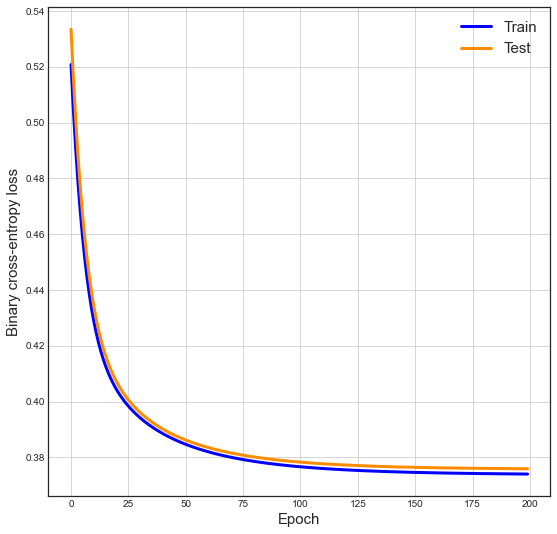

In [15]:
logistic.cost_epoch(xte, yte)
cs = logistic.c_epoch[:200, :]
cs_te = logistic.c_te_epoch[:200, :]
bs = logistic.b_epoch[:200, :]  # used later when plotting contour
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.plot(cs, linewidth=3, c="blue", label="Train")
plt.plot(cs_te, linewidth=3, c="darkorange", label="Test")
plt.legend()
plt.show()

## Plot cost function contour

### Static

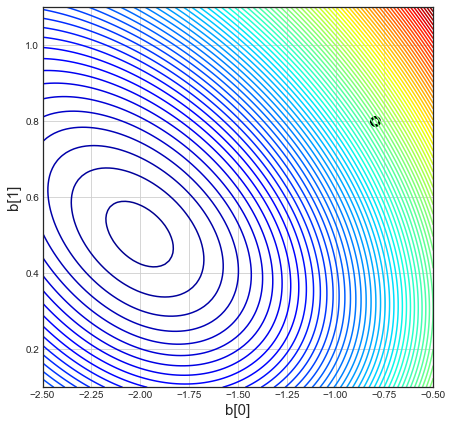

In [16]:
# values for parameters 0 and 1 (use true values for parameters 2 and 3)
B0, B1 = np.meshgrid(np.linspace(-2.5, -0.5, 100), np.linspace(0.1, 1.1, 100))

# cost function
def cost(x, y, b):
    yhat = scipy.special.expit(np.dot(x, b))
    cost_i = -(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
    return np.mean(cost_i)


# span grid for parameters 0 and 1, use true values for parameters 2 and 3
zs = np.array(
    [
        cost(x, y, np.array([b0, b1, b_true[2], b_true[3]]))
        for b0, b1 in zip(np.ravel(B0), np.ravel(B1))
    ]
)
Z = zs.reshape(B0.shape)

# contour plot
fig1, ax1 = plt.subplots(figsize=(7, 7))
ax1.contour(B0, B1, Z, 100, cmap="jet")
ax1.set_xlabel("b[0]")
ax1.set_ylabel("b[1]")

# plot starting point for MBGD
plt.scatter(logistic.b_epoch[0, 0], logistic.b_epoch[0, 1], c="black", s=100)
plt.scatter(logistic.b_epoch[0, 0], logistic.b_epoch[0, 1], c="white", s=20)

plt.show()

### Animated

In [17]:
def init_1():
    line1.set_data([], [])
    point1.set_data([], [])
    value_display1.set_text("")
    return line1, point1, value_display1


def animate_1(i):
    p_i = p[i]
    line1.set_data(bs[:p_i, 0], bs[:p_i, 1])
    point1.set_data(bs[p_i, 0], bs[p_i, 1])
    value_display1.set_text(f"Cost  = {cs[p_i, 0]:.4f}")
    return line1, point1, value_display1


p = np.arange(bs.shape[0])

linewidth = 2
marker_size = 5

(line1,) = ax1.plot([], [], "m", label="MBGD", linewidth=linewidth)
(point1,) = ax1.plot([], [], "*", color="m", markersize=marker_size)
value_display1 = ax1.text(0.02, 0.06, "", transform=ax1.transAxes)
value_display1.set_bbox(dict(facecolor="white", alpha=0.9, edgecolor="white"))

_ = ax1.legend(loc=1)

anim1 = matplotlib.animation.FuncAnimation(
    fig1,
    animate_1,
    init_func=init_1,
    frames=len(p),
    interval=100,
    repeat_delay=60,
    blit=True,
)

# anim1.save("../source/_static/img/gd-contour-logistic.gif", writer="pillow", dpi=100)

<img src=https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/gd-contour-logistic.gif width="600">

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
`Learning from Big Data`, Module 2, Lecture 05 <br>
2021/22 <br>